## Test against r3d2

Assumes already have pyro data stored in basedir.

In [1]:
from __future__ import division
from r3d2 import State, RiemannProblem, eos_defns, wave
from IPython.display import display, display_png, display_svg

In [3]:
# imports for pyro stuff
import matplotlib # these two lines set the display so it works
import matplotlib.pyplot as plt
% matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from matplotlib import rc
plt.rc("font", size=18, family='serif')
import sys
import os
import getopt
import importlib
import numpy as np

import mesh.patch as patch
from util import runparams, msg
import compressible_gr.cons_to_prim as cy

In [88]:
# What tangential velocity do we want?
vt = 0.0

In [175]:
# set up parameters for pyro plotting
my_dpi = 96.
W = 1920/my_dpi
H = 1080/my_dpi
solver_name = 'compressible_gr'
problem_name = 'sod'
basedir = '/media/alice/TOSHIBA EXT/pyro/results'
resolution = '1024_rp3' 
plot_fig_no = 500

vmins = [0., None, -0.05, 0.]
vmaxes = [None, None, 1.05, None]

base = basedir + "/" + problem_name + "/" + problem_name + "_" + str(resolution) + '_' + format(plot_fig_no, '05')

In [176]:
try:
    file = base + '.pyro'
except:
    print('No file exists by the name {}.pyro!'.format(base))  
    
try:
    myg, myd = patch.read(file)
except IOError:
    print('Can\'t read file')

In [177]:
solver = importlib.import_module(solver_name)

rp = runparams.RuntimeParameters()
rp.load_params("_defaults")
rp.load_params(solver_name + "/_defaults")

# problem-specific runtime parameters
rp.load_params(solver_name + "/problems/_" + problem_name + ".defaults")
param_file = 'inputs.' + problem_name

# now read in the inputs file
if not os.path.isfile(param_file):
    # check if the param file lives in the solver's problems directory
    param_file = solver_name + "/problems/" + param_file
    if not os.path.isfile(param_file):
        print(param_file)
        msg.fail("ERROR: inputs file does not exist")

rp.load_params(param_file, no_new=1)
init_tstep_factor = rp.get_param("driver.init_tstep_factor")
max_dt_change = rp.get_param("driver.max_dt_change")
fix_dt = rp.get_param("driver.fix_dt")

sim = solver.SimulationReact(solver_name, problem_name, rp)

sim.cc_data = myd

In [178]:
myg = sim.cc_data.grid

D = sim.cc_data.get_var("D")
DX = sim.cc_data.get_var("DX")
Sx = sim.cc_data.get_var("Sx")
Sy = sim.cc_data.get_var("Sy")
tau = sim.cc_data.get_var("tau")

gamma = sim.cc_data.get_aux("gamma")
c = sim.cc_data.get_aux("c")

rho = myg.scratch_array()
p = myg.scratch_array()
X = myg.scratch_array()
u = myg.scratch_array()
v = myg.scratch_array()
h = myg.scratch_array()
S = myg.scratch_array()

U = myg.scratch_array(sim.vars.nvar)
U.d[:,:,sim.vars.iD] = D.d
U.d[:,:,sim.vars.iSx] = Sx.d
U.d[:,:,sim.vars.iSy] = Sy.d
U.d[:,:,sim.vars.itau] = tau.d
U.d[:,:,sim.vars.iDX] = DX.d

V = myg.scratch_array(sim.vars.nvar)
V.d[:,:,:] = cy.cons_to_prim(U.d, c, gamma, myg.qx, myg.qy, sim.vars.nvar, sim.vars.iD, sim.vars.iSx, sim.vars.iSy, sim.vars.itau, sim.vars.iDX)

rho.d[:,:] = V.d[:,:,sim.vars.irho]
u.d[:,:] = V.d[:,:,sim.vars.iu]
v.d[:,:] = V.d[:,:,sim.vars.iv]
p.d[:,:] = V.d[:,:,sim.vars.ip]
h.d[:,:] = V.d[:,:,sim.vars.itau]
X.d[:,:] = V.d[:,:,sim.vars.iX]

# get the velocity magnitude
magvel = myg.scratch_array()
magvel.d[:,:] = np.sqrt(u.d**2 + v.d**2)

def discrete_Laplacian(f):
    return (f.ip(1) - 2.*f.v() + f.ip(-1)) / myg.dx**2 + \
           (f.jp(1) - 2.*f.v() + f.jp(-1)) / myg.dy**2

T = sim.calc_T(p, D, X, rho)
#T.d[:,:] = np.log(T.d)

vort = myg.scratch_array()

dv = 0.5 * (v.ip(1) - v.ip(-1)) / myg.dx
du = 0.5 * (u.jp(1) - u.jp(-1)) / myg.dy

vort.v()[:,:] = dv - du

In [179]:
def figure_data(rp, format):
    plt.figure()
    fig, axs = plt.subplots(3,3)
    ax = axs[0,0]
    for w in rp.waves[0], rp.waves[2]:
        if len(w.wavespeed)==1:
            ax.plot([0, w.wavespeed[0]], [0, 1], 'k-', linewidth=3)
        elif len(w.wavespeed)==2:
            xi_end = np.linspace(w.wavespeed[0], w.wavespeed[1], 5)
            ax.fill_between([0, xi_end[0], xi_end[-1], 0],
                            [0, 1, 1, 0], color='k', alpha=0.1)
            for xi in xi_end:
                ax.plot([0, xi], [0, 1], 'k-', linewidth=1)
    if len(rp.waves[1].wavespeed):
        ax.plot([0, rp.waves[1].wavespeed[0]], [0, 1], 'k--', linewidth=1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$t$")
    ax.set_title("Characteristics")
    names = [r"$\rho$", r"$v$", r"$v_t$", r"$\epsilon$", r"$p$", r"$W$",
             r"$h$", r"$c_s$"]
    xi = [-1.05]
    data = rp.state_l.state()
    for wave in rp.waves:
        xi_wave, data_wave = wave.plotting_data()
        xi = np.hstack((xi, xi_wave))
        data = np.vstack((data, data_wave))
    xi = np.hstack((xi, [1.05]))
    data = np.vstack((data, rp.state_r.state()))
    for ax_j in range(3):
        for ax_i in range(3):
            if ax_i == 0 and ax_j == 0:
                continue
            nvar = ax_i*3 + ax_j - 1
            axs[ax_i, ax_j].plot(xi, data[:, nvar])
            var_max = np.max(data[:, nvar])
            var_min = np.min(data[:, nvar])
            d_var = max(var_max - var_min,
                        0.01 * min(abs(var_min), abs(var_max)), 0.01)
            axs[ax_i, ax_j].set_xlim(-1.05, 1.05)
            axs[ax_i, ax_j].set_ylim(var_min - 0.05 * d_var,
                                     var_max + 0.05 * d_var)
            axs[ax_i, ax_j].set_xlabel(r"$\xi$")
            axs[ax_i, ax_j].set_ylabel(names[nvar])
    fig.tight_layout()
    plt.show()

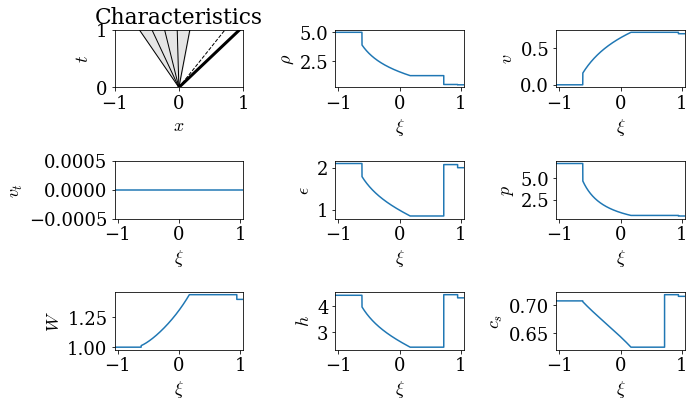

In [180]:
# set up R3D2 problem
eos = eos_defns.eos_gamma_law(5.0/3.0)
eos_reactive = eos_defns.eos_gamma_law_react(5.0/3.0, 0.1, 1.0, 1.0, eos)
test_1_w_left = State(10.0, 0.0, 0.0, 2.0, eos, label="L")
test_1_w_right = State(2.0, 0.0, 0.0, 0.5, eos, label="R")
test_1_rp = RiemannProblem(test_1_w_left, test_1_w_right)
test_2_w_left = State(1.0, 0.0, 0.0, 10.0, eos, label="L")
test_2_w_right = State(1.0, 0.0, 0.0, 1.0, eos, label="R")
test_2_rp = RiemannProblem(test_2_w_left, test_2_w_right)
test_3_w_left = State(1.0, 0.0, 0.0, 10, eos, label="L")
test_3_w_right = State(1.0, 0.0, 0.9, 1.0, eos, label="R")
test_3_rp = RiemannProblem(test_3_w_left, test_3_w_right)
test_4_w_left = State(1.0, 0.0, 0.9, 10.0, eos, label="L")
test_4_w_right = State(1.0, 0.0, 0.9, 1.0, eos, label="R")
test_4_rp = RiemannProblem(test_4_w_left, test_4_w_right)
test_8_w_left = State(1.0, 0.0, 0.999, 10.0, eos, label="L")
test_8_w_right = State(1.0, 0.0, 0.999, 1.0, eos, label="R")
test_8_rp = RiemannProblem(test_8_w_left, test_8_w_right)
test_6_U_reactive = State(5.0, 0.0, 0.0, 2.1, eos_reactive)
test_6_U_burnt = State(0.5, 0.7, 0.0, 2.0, eos)
test_6_rp = RiemannProblem(test_6_U_reactive, test_6_U_burnt)
test_6_rp

<Figure size 720x576 with 0 Axes>

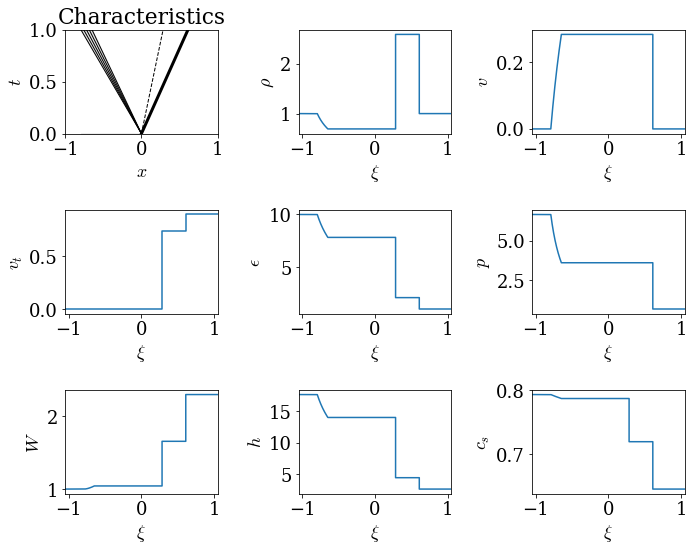

In [181]:
figure_data(test_3_rp, 'png')

Now let's try to make some plots of pyro and R3D2 data

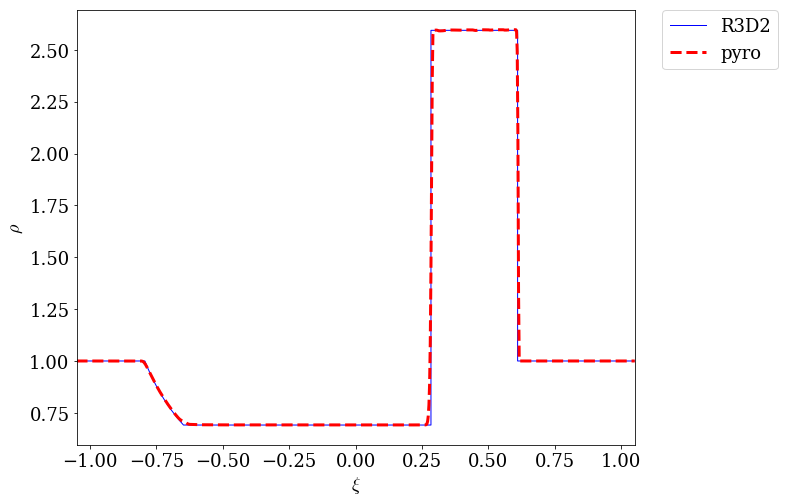

In [189]:
# extract density from both and plot
# have rho.d above for pyro, now find the R3D2 density and change from xi to t 

xis = (myg.x - 0.5) / sim.cc_data.t

xi = [-1.05]
data = test_3_rp.state_l.state()
for wave in test_3_rp.waves:
    xi_wave, data_wave = wave.plotting_data()
    xi = np.hstack((xi, xi_wave))
    data = np.vstack((data, data_wave))
xi = np.hstack((xi, [1.05]))
data = np.vstack((data, test_3_rp.state_r.state()))

r3d2_rho = data[:, 0]
r3d2_p = data[:, 4]
r3d2_v = data[:, 1]
r3d2_vt = data[:, 2]
r3d2_h = data[:, 6]

plt.figure()
plt.rc("font", size=18)
plt.plot(xi, r3d2_rho, 'b', label='R3D2', linewidth=1)
plt.plot(xis, rho.d[:,6], '--r', label='pyro', linewidth=3)

plt.xlim([-1.05, 1.05])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\rho$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

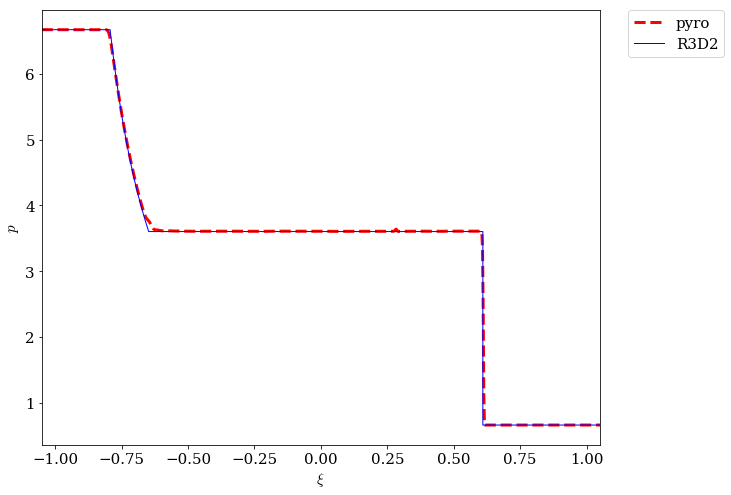

In [190]:
plt.figure()
plt.rc("font", size=15)
plt.plot(xis, p.d[:,6], '--r', label='pyro', linewidth=3)
plt.plot(xi, r3d2_p, 'b', label='R3D2', linewidth=1)
plt.xlim([-1.05, 1.05])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$p$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

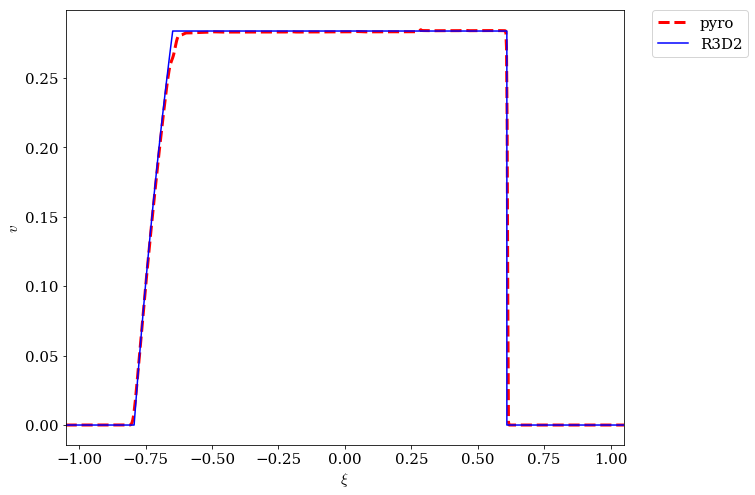

In [191]:
plt.figure()
plt.rc("font", size=15)
plt.plot(xis, u.d[:,6], '--r', label='pyro', linewidth=3)
plt.plot(xi, r3d2_v, 'b', label='R3D2')
plt.xlim([-1.05, 1.05])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$v$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

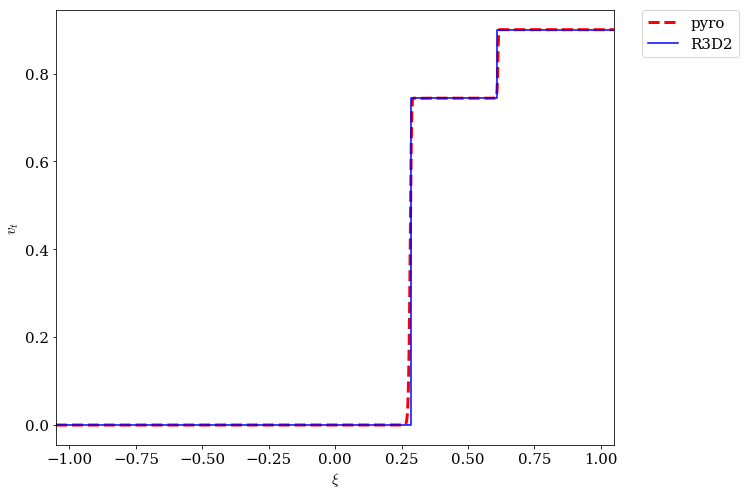

In [192]:
plt.figure()
plt.rc("font", size=15)
plt.plot(xis, v.d[:,6], '--r', label='pyro', linewidth=3)
plt.plot(xi, r3d2_vt, 'b', label='R3D2')
plt.xlim([-1.05, 1.05])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$v_t$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

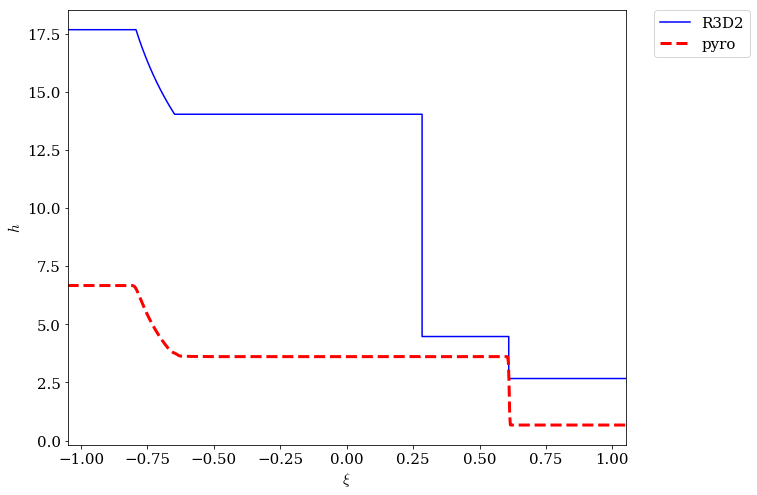

In [193]:
plt.figure()
plt.rc("font", size=15)
plt.plot(xi, r3d2_h, 'b', label='R3D2')
plt.plot(xis, h.d[:,6], '--r', label='pyro', linewidth=3)

plt.xlim([-1.05, 1.05])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$h$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [194]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
plt.rc("font", size=18)

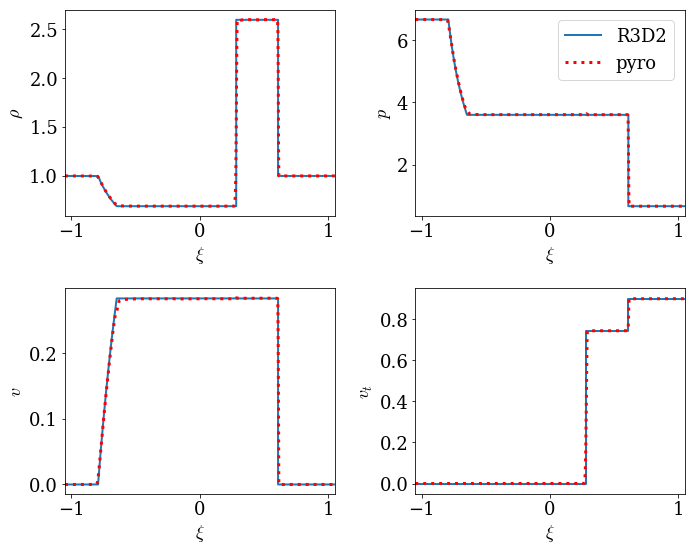

In [196]:
# do we want to save?
to_save = True

fig, axs = plt.subplots(2,2)
#print(xi)
# density 
axs[0,0].plot(xi, r3d2_rho, '-', label='R3D2', linewidth=2)
axs[0,0].plot(xis, rho.d[:,6], 'r:', label='pyro', linewidth=3)
axs[0,0].set_xlim([-1.05, 1.05])
axs[0,0].set_xlabel(r'$\xi$')
axs[0,0].set_ylabel(r'$\rho$')

# pressure
axs[0,1].plot(xi, r3d2_p, '-', label='R3D2', linewidth=2)
axs[0,1].plot(xis, p.d[:,6], 'r:', label='pyro', linewidth=3)
axs[0,1].set_xlim([-1.05, 1.05])
axs[0,1].set_xlabel(r'$\xi$')
axs[0,1].set_ylabel(r'$p$')

# v
axs[1,0].plot(xi, r3d2_v, '-', label='R3D2', linewidth=2)
axs[1,0].set_xlim([-1.05, 1.05])
axs[1,0].plot(xis, u.d[:,6], 'r:', label='pyro', linewidth=3)
axs[1,0].set_xlabel(r'$\xi$')
axs[1,0].set_ylabel(r'$v$')

# vt
axs[1,1].plot(xi, r3d2_vt, '-', label='R3D2', linewidth=2)
axs[1,1].plot(xis, v.d[:,6], 'r:', label='pyro', linewidth=3)
axs[1,1].set_xlim([-1.05, 1.05])
max_v = max(max(v.d[:,6]), max(r3d2_vt))
axs[1,1].set_ylim([-0.05, max_v+0.05])
axs[1,1].set_xlabel(r'$\xi$')
axs[1,1].set_ylabel(r'$v_t$')

# h
#axs[2,0].plot(xis, h.d[:,6]*0.2+2, '--r', label='pyro', linewidth=3)
#axs[2,0].plot(xi, r3d2_h, 'b', label='R3D2')
#axs[2,0].set_xlim([-1.05, 1.05])
#axs[2,0].set_xlabel(r'$\xi$')
#axs[2,0].set_ylabel(r'$h$')

fig.tight_layout()
lgd = axs[0,1].legend(bbox_to_anchor=(0.53, 0.95), loc=2, borderaxespad=0.)

#save me
outfile = "/home/alice/writing/figures/rp3_v_pyro"
if to_save:
    plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
outfile = "/home/alice/Dropbox/Writing/figures/rp3_v_pyro"
if to_save:
    plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# RHLLE vs RHLLC

In [250]:
# set up parameters for pyro plotting
my_dpi = 96.
W = 1920/my_dpi
H = 1080/my_dpi
solver_name = 'compressible_gr'
problem_name = 'sod'
basedir = '/home/alice/Documents/Work/pyro/results/'
resolution = '128_rp3_hlle' 
plot_fig_no = 50

vmins = [0., None, -0.05, 0.]
vmaxes = [None, None, 1.05, None]

base = basedir + "/" + problem_name + "/" + problem_name + "_" + str(resolution) + '_' + format(plot_fig_no, '05')

In [251]:
try:
    file = base + '.pyro'
except:
    print('No file exists by the name {}.pyro!'.format(base))  
    
try:
    myg, myd = patch.read(file)
except IOError:
    print('Can\'t read file')

In [252]:
solver = importlib.import_module(solver_name)

rp = runparams.RuntimeParameters()
rp.load_params("_defaults")
rp.load_params(solver_name + "/_defaults")

# problem-specific runtime parameters
rp.load_params(solver_name + "/problems/_" + problem_name + ".defaults")
param_file = 'inputs.' + problem_name

# now read in the inputs file
if not os.path.isfile(param_file):
    # check if the param file lives in the solver's problems directory
    param_file = solver_name + "/problems/" + param_file
    if not os.path.isfile(param_file):
        print(param_file)
        msg.fail("ERROR: inputs file does not exist")

rp.load_params(param_file, no_new=1)
init_tstep_factor = rp.get_param("driver.init_tstep_factor")
max_dt_change = rp.get_param("driver.max_dt_change")
fix_dt = rp.get_param("driver.fix_dt")

sim = solver.SimulationReact(solver_name, problem_name, rp)

sim.cc_data = myd

In [253]:
myg = sim.cc_data.grid

D = sim.cc_data.get_var("D")
DX = sim.cc_data.get_var("DX")
Sx = sim.cc_data.get_var("Sx")
Sy = sim.cc_data.get_var("Sy")
tau = sim.cc_data.get_var("tau")

gamma = sim.cc_data.get_aux("gamma")
c = sim.cc_data.get_aux("c")

rho = myg.scratch_array()
p = myg.scratch_array()
X = myg.scratch_array()
u = myg.scratch_array()
v = myg.scratch_array()
h = myg.scratch_array()
S = myg.scratch_array()

U = myg.scratch_array(sim.vars.nvar)
U.d[:,:,sim.vars.iD] = D.d
U.d[:,:,sim.vars.iSx] = Sx.d
U.d[:,:,sim.vars.iSy] = Sy.d
U.d[:,:,sim.vars.itau] = tau.d
U.d[:,:,sim.vars.iDX] = DX.d

V = myg.scratch_array(sim.vars.nvar)
V.d[:,:,:] = cy.cons_to_prim(U.d, c, gamma, myg.qx, myg.qy, sim.vars.nvar, sim.vars.iD, sim.vars.iSx, sim.vars.iSy, sim.vars.itau, sim.vars.iDX)

rho.d[:,:] = V.d[:,:,sim.vars.irho]
u.d[:,:] = V.d[:,:,sim.vars.iu]
v.d[:,:] = V.d[:,:,sim.vars.iv]
p.d[:,:] = V.d[:,:,sim.vars.ip]
h.d[:,:] = V.d[:,:,sim.vars.itau]
X.d[:,:] = V.d[:,:,sim.vars.iX]

# get the velocity magnitude
magvel = myg.scratch_array()
magvel.d[:,:] = np.sqrt(u.d**2 + v.d**2)

def discrete_Laplacian(f):
    return (f.ip(1) - 2.*f.v() + f.ip(-1)) / myg.dx**2 + \
           (f.jp(1) - 2.*f.v() + f.jp(-1)) / myg.dy**2

T = sim.calc_T(p, D, X, rho)
#T.d[:,:] = np.log(T.d)

vort = myg.scratch_array()

dv = 0.5 * (v.ip(1) - v.ip(-1)) / myg.dx
du = 0.5 * (u.jp(1) - u.jp(-1)) / myg.dy

vort.v()[:,:] = dv - du

xis = (myg.x - 0.5) / sim.cc_data.t

In [254]:
# set up parameters for pyro plotting
my_dpi = 96.
W = 1920/my_dpi
H = 1080/my_dpi
solver_name = 'compressible_gr'
problem_name = 'sod'
basedir = '/home/alice/Documents/Work/pyro/results/'
resolution = '128_rp3_hllc' 
plot_fig_no = 50

vmins = [0., None, -0.05, 0.]
vmaxes = [None, None, 1.05, None]

base = basedir + "/" + problem_name + "/" + problem_name + "_" + str(resolution) + '_' + format(plot_fig_no, '05')

In [255]:
try:
    file = base + '.pyro'
except:
    print('No file exists by the name {}.pyro!'.format(base))  
    
try:
    myg, myd = patch.read(file)
except IOError:
    print('Can\'t read file')

In [256]:
solver = importlib.import_module(solver_name)

rp = runparams.RuntimeParameters()
rp.load_params("_defaults")
rp.load_params(solver_name + "/_defaults")

# problem-specific runtime parameters
rp.load_params(solver_name + "/problems/_" + problem_name + ".defaults")
param_file = 'inputs.' + problem_name

# now read in the inputs file
if not os.path.isfile(param_file):
    # check if the param file lives in the solver's problems directory
    param_file = solver_name + "/problems/" + param_file
    if not os.path.isfile(param_file):
        print(param_file)
        msg.fail("ERROR: inputs file does not exist")

rp.load_params(param_file, no_new=1)
init_tstep_factor = rp.get_param("driver.init_tstep_factor")
max_dt_change = rp.get_param("driver.max_dt_change")
fix_dt = rp.get_param("driver.fix_dt")

sim = solver.SimulationReact(solver_name, problem_name, rp)

sim.cc_data = myd

In [257]:
myg = sim.cc_data.grid

D = sim.cc_data.get_var("D")
DX = sim.cc_data.get_var("DX")
Sx = sim.cc_data.get_var("Sx")
Sy = sim.cc_data.get_var("Sy")
tau = sim.cc_data.get_var("tau")

gamma = sim.cc_data.get_aux("gamma")
c = sim.cc_data.get_aux("c")

rho_c = myg.scratch_array()
p_c = myg.scratch_array()
X_c = myg.scratch_array()
u_c = myg.scratch_array()
v_c = myg.scratch_array()
h_c = myg.scratch_array()
S_c = myg.scratch_array()

U_c = myg.scratch_array(sim.vars.nvar)
U_c.d[:,:,sim.vars.iD] = D.d
U_c.d[:,:,sim.vars.iSx] = Sx.d
U_c.d[:,:,sim.vars.iSy] = Sy.d
U_c.d[:,:,sim.vars.itau] = tau.d
U_c.d[:,:,sim.vars.iDX] = DX.d

V_c = myg.scratch_array(sim.vars.nvar)
V_c.d[:,:,:] = cy.cons_to_prim(U_c.d, c, gamma, myg.qx, myg.qy, sim.vars.nvar, sim.vars.iD, sim.vars.iSx, sim.vars.iSy, sim.vars.itau, sim.vars.iDX)

rho_c.d[:,:] = V_c.d[:,:,sim.vars.irho]
u_c.d[:,:] = V_c.d[:,:,sim.vars.iu]
v_c.d[:,:] = V_c.d[:,:,sim.vars.iv]
p_c.d[:,:] = V_c.d[:,:,sim.vars.ip]
h_c.d[:,:] = V_c.d[:,:,sim.vars.itau]
X_c.d[:,:] = V_c.d[:,:,sim.vars.iX]

# get the velocity magnitude
magvel = myg.scratch_array()
magvel.d[:,:] = np.sqrt(u_c.d**2 + v_c.d**2)

def discrete_Laplacian(f):
    return (f.ip(1) - 2.*f.v() + f.ip(-1)) / myg.dx**2 + \
           (f.jp(1) - 2.*f.v() + f.jp(-1)) / myg.dy**2

# T = sim.calc_T(p, D, X, rho)
#T.d[:,:] = np.log(T.d)

# vort = myg.scratch_array()

# dv = 0.5 * (v.ip(1) - v.ip(-1)) / myg.dx
# du = 0.5 * (u.jp(1) - u.jp(-1)) / myg.dy

# vort.v()[:,:] = dv - du

xis = (myg.x - 0.5) / sim.cc_data.t

In [258]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
plt.rc("font", size=18)

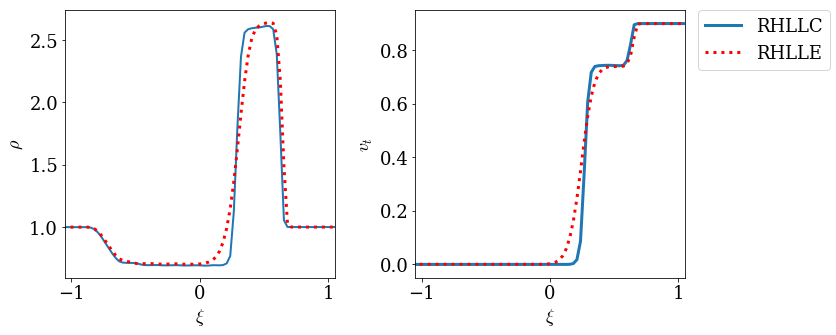

In [268]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
plt.rc("font", size=18)

# do we want to save?
to_save = True

fig, axs = plt.subplots(1,2)
#print(xi)
# density 
axs[0].plot(xis, rho_c.d[:,6], '-', label='RHLLC', linewidth=2)
axs[0].plot(xis, rho.d[:,6], 'r:', label='RHLLE', linewidth=3)
axs[0].set_xlim([-1.05, 1.05])
axs[0].set_xlabel(r'$\xi$')
axs[0].set_ylabel(r'$\rho$')

# # pressure
# axs[0,1].plot(xis, p_c.d[:,6], '-', label='RHLLC', linewidth=3)
# axs[0,1].plot(xis, p.d[:,6], 'r:', label='RHLLE', linewidth=3)
# axs[0,1].set_xlim([-1.05, 1.05])
# axs[0,1].set_xlabel(r'$\xi$')
# axs[0,1].set_ylabel(r'$p$')

# # v

# axs[1,0].set_xlim([-1.05, 1.05])
# axs[1,0].plot(xis, u_c.d[:,6], '-', label='RHLLC', linewidth=3)
# axs[1,0].plot(xis, u.d[:,6], 'r:', label='RHLLE', linewidth=3)
# axs[1,0].set_xlabel(r'$\xi$')
# axs[1,0].set_ylabel(r'$v$')

# vt
axs[1].plot(xis, v_c.d[:,6], '-', label='RHLLC', linewidth=3)
axs[1].plot(xis, v.d[:,6], 'r:', label='RHLLE', linewidth=3)
axs[1].set_xlim([-1.05, 1.05])
max_v = max(max(v.d[:,6]), max(r3d2_vt))
axs[1].set_ylim([-0.05, max_v+0.05])
axs[1].set_xlabel(r'$\xi$')
axs[1].set_ylabel(r'$v_t$')

# h
#axs[2,0].plot(xis, h.d[:,6]*0.2+2, '--r', label='pyro', linewidth=3)
#axs[2,0].plot(xi, r3d2_h, 'b', label='R3D2')
#axs[2,0].set_xlim([-1.05, 1.05])
#axs[2,0].set_xlabel(r'$\xi$')
#axs[2,0].set_ylabel(r'$h$')

fig.tight_layout()
lgd = axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#save me
outfile = "/home/alice/writing/figures/sod_rp3_hlle_vs_hllc"
if to_save:
    plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
outfile = "/home/alice/Dropbox/Writing/figures/sod_rp3_hlle_vs_hllc"
if to_save:
    plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()